## Title
### Smaller
Note

In [25]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import math
import seaborn as sns
import CPTAC

In [224]:
### Step 2 getting TP53 mutation status done in a simple df
clinical_full = CPTAC.get_clinical() 
clinical = clinical_full[['Proteomics_Participant_ID', 'Histologic_Grade_FIGO', 'Myometrial_invasion_Specify', 'Histologic_type', 'FIGO_stage']]
clinical.head()
proteomics = CPTAC.get_proteomics()
somatic = CPTAC.get_somatic()
gene = 'TP53' 
protein = 'TP53'

##Identifying Hotspot Patients
hotspot_mutations = ['p.P250L', 'p.R248W', 'p.S241C', 'p.S241del', 'p.K164E', 'p.R249S', 'p.R273H', 'p.R282W',
                    'p.S127Y', 'p.G244D', 'p.A159P']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Patient_Id']

df_TP53 = clinical.loc[(clinical['Proteomics_Participant_ID'].isin(hotspot_patients))]

clinical['P53_hotspot'] = 'No'
clinical.loc[clinical['Proteomics_Participant_ID'].isin(hotspot_patients), 'P53_hotspot'] = 'Yes'

loc_compare = CPTAC.compare_mutations(proteomics, protein, gene)

clinical = clinical.join(loc_compare)
tumor_clinical = clinical.loc[clinical['Patient_Type'] == 'Tumor']

clinical_full = clinical_full.join(loc_compare)
clinical_full = clinical_full.loc[clinical_full['Patient_Type'] == 'Tumor']

clinical_full = clinical_full.set_index('Proteomics_Participant_ID')
clinical = clinical.set_index('Proteomics_Participant_ID')

clinical_full['Within_Hotspot'] = False
clinical_full.loc[hotspot_patients, 'Within_Hotspot'] = True
clinical_full.loc[clinical_full['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'WT'

clinical['Within_Hotspot'] = False
clinical.loc[hotspot_patients, 'Within_Hotspot'] = True

clinical.loc[clinical['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'WT'


/Users/jonjarman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jonjarman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [232]:
#create BF correction
Chi_Tests = 0
for feature in clinical_full:
    if str(clinical_full[feature].dtypes) == 'object':
        Chi_Tests += 1
print(Chi_Tests)
BF = 0.05/Chi_Tests

for feature in clinical_full:
    if str(clinical_full[feature].dtypes) == 'object':
        chi_clinical = pd.crosstab(clinical_full[feature], clinical_full['Within_Hotspot'])
        chi_test = scipy.stats.chi2_contingency(observed = chi_clinical)
        if chi_test[1] <= BF:
            print(feature)
            print (chi_test)
            
chi_test = pd.crosstab(clinical_full['Histologic_type'], clinical_full['Within_Hotspot'])
print (chi_test)
            

63
Histologic_type
(55.67855792454722, 3.380768455237439e-10, 6, array([[ 0.33,  0.36,  2.31],
       [ 0.11,  0.12,  0.77],
       [ 9.35, 10.2 , 65.45],
       [ 1.21,  1.32,  8.47]]))
p53
(33.96864299302473, 4.116152318250829e-05, 8, array([[ 8.46938776, 10.16326531, 64.36734694],
       [ 0.20408163,  0.24489796,  1.55102041],
       [ 0.71428571,  0.85714286,  5.42857143],
       [ 0.40816327,  0.48979592,  3.10204082],
       [ 0.20408163,  0.24489796,  1.55102041]]))
CNV_clustering
(51.97907477025898, 5.162824073264053e-12, 2, array([[ 2.16494845,  2.59793814, 16.2371134 ],
       [ 7.83505155,  9.40206186, 58.7628866 ]]))
Within_Hotspot
(200.0, 3.75727673578106e-42, 4, array([[ 1.21,  1.32,  8.47],
       [ 1.32,  1.44,  9.24],
       [ 8.47,  9.24, 59.29]]))
Mutation
(150.21645021645023, 5.1245812424676625e-26, 12, array([[ 0.22,  0.24,  1.54],
       [ 0.11,  0.12,  0.77],
       [ 0.11,  0.12,  0.77],
       [ 1.54,  1.68, 10.78],
       [ 0.44,  0.48,  3.08],
       [ 0.11,

In [148]:
BF = 0.05/101

hotspot = clinical_full.loc[clinical_full['Within_Hotspot'] == True]
non_hotspot = clinical_full.loc[clinical_full['Within_Hotspot'] != True]
wildtype = clinical_full.loc[clinical_full['Within_Hotspot'] == 'WT']
TP53_mutation = clinical_full.loc[clinical_full['Within_Hotspot'] != 'WT']


##P53 Hotspot vs. All Mutations
print('HOTSPOT vs. EVERYTHING')
sig_dict1 = {}
sig_dict = {}
sig_list = []
for feature in clinical_full:
    if str(clinical_full[feature].dtypes) == 'float64' or str(clinical_full[feature].dtypes) == 'int64':
        ttest = scipy.stats.ttest_ind(hotspot[feature].dropna(axis=0), non_hotspot[feature].dropna(axis = 0))
        TTest += 1
        if ttest[1] <= BF:
            sig_list.append(feature)
            sig_dict1[feature] = ttest[1]
            print(feature)
            print(ttest)
            print('\n')
        
##P53 TP53 Mutation vs. Wildtype
print('TP53 Mutation vs. WILDTYPE')
for feature in clinical_full:
    if str(clinical_full[feature].dtypes) == 'float64' or str(clinical_full[feature].dtypes) == 'int64':
        ttest = scipy.stats.ttest_ind(TP53_mutation[feature].dropna(axis=0), wildtype[feature].dropna(axis = 0))
        TTest += 1
        if ttest[1] <= BF:
            if feature in sig_dict1:
                print('***DUPLICATE***')
            else:
                sig_list.append(feature)
            print(feature)
            print(ttest)
            print('\n')
            





        
    

HOTSPOT vs. EVERYTHING
Pathway_activity_JAK.STAT
Ttest_indResult(statistic=4.630135454670901, pvalue=1.1459321916777611e-05)


Pathway_activity_p53
Ttest_indResult(statistic=-3.6804427342069204, pvalue=0.0003844583430094881)


TP53_TP53
Ttest_indResult(statistic=9.073036977771004, pvalue=1.2427601997591117e-14)


TP53_pathway
Ttest_indResult(statistic=6.323290282756281, pvalue=7.631134263843974e-09)


PI3K_pathway
Ttest_indResult(statistic=-4.601540310411988, pvalue=1.2570312529827001e-05)


Mutation_signature_C>G
Ttest_indResult(statistic=3.6681972621248016, pvalue=0.00039723548501066115)


TP53
Ttest_indResult(statistic=8.854794158768678, pvalue=9.722321381617046e-14)


TP53 Mutation vs. WILDTYPE
LVSI
Ttest_indResult(statistic=4.373790901875431, pvalue=3.100302642560359e-05)


Estrogen_Receptor_%
Ttest_indResult(statistic=-3.856544626291203, pvalue=0.0004717873744776047)


***DUPLICATE***
Pathway_activity_JAK.STAT
Ttest_indResult(statistic=5.414651489765074, pvalue=4.528219552713036e

In [160]:
CPTAC.define("Race")

Race not found in dictionary. Alternatively, CPTAC.define() can be used to perform a web search of the term provided.


In [157]:
l = clinical_full.columns
print(list(l))

['Proteomics_TMT_batch', 'Proteomics_TMT_plex', 'Proteomics_TMT_channel', 'Proteomics_Parent_Sample_IDs', 'Proteomics_Aliquot_ID', 'Proteomics_Tumor_Normal', 'Proteomics_OCT', 'Country', 'Histologic_Grade_FIGO', 'Myometrial_invasion_Specify', 'Histologic_type', 'Treatment_naive', 'Tumor_purity', 'Case_quality', 'Path_Stage_Primary_Tumor-pT', 'Path_Stage_Reg_Lymph_Nodes-pN', 'Clin_Stage_Dist_Mets-cM', 'Path_Stage_Dist_Mets-pM', 'tumor_Stage-Pathological', 'FIGO_stage', 'LVSI', 'BMI', 'Age', 'Diabetes', 'Race', 'Ethnicity', 'Gender', 'Tumor_Site', 'Tumor_Site_Other', 'Tumor_Focality', 'Tumor_Size_cm', 'Estrogen_Receptor', 'Estrogen_Receptor_%', 'Progesterone_Receptor', 'Progesterone_Receptor_%', 'MLH1', 'MLH2', 'MSH6', 'PMS2', 'p53', 'Other_IHC_specify', 'MLH1_Promoter_Hypermethylation', 'Num_full_term_pregnancies', 'EPIC_Bcells', 'EPIC_CAFs', 'EPIC_CD4_Tcells', 'EPIC_CD8_Tcells', 'EPIC_Endothelial', 'EPIC_Macrophages', 'EPIC_NKcells', 'EPIC_otherCells', 'CIBERSORT_B _cells _naive', 'CIB

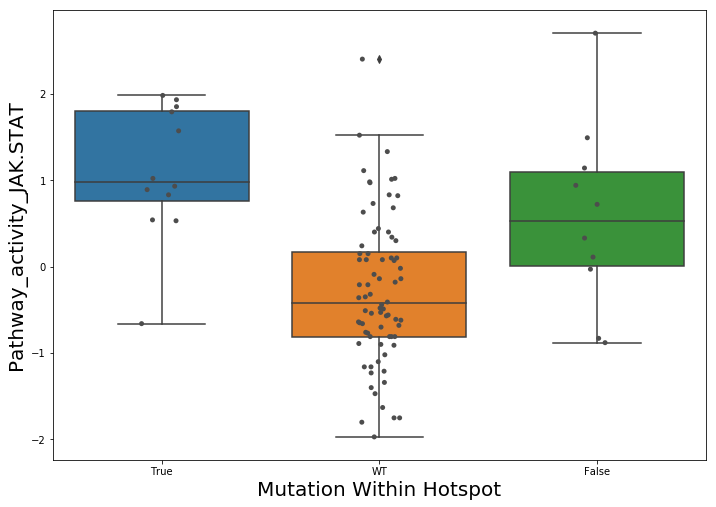

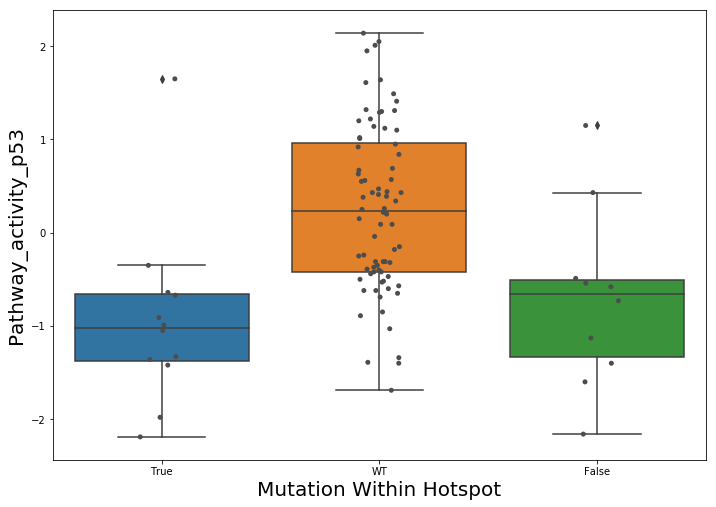

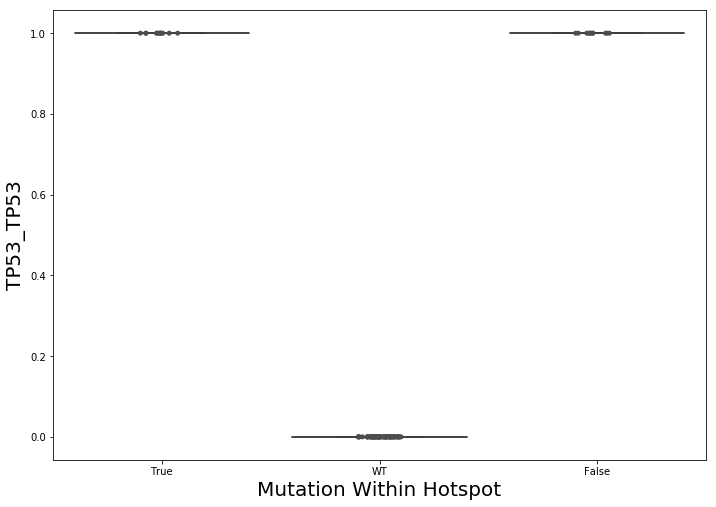

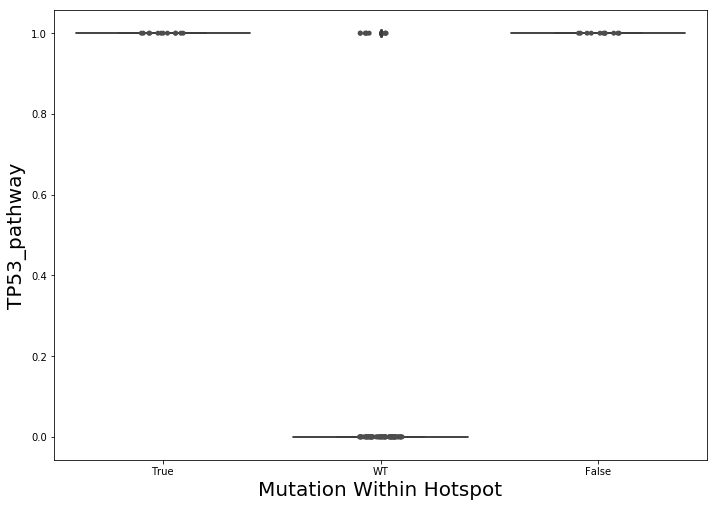

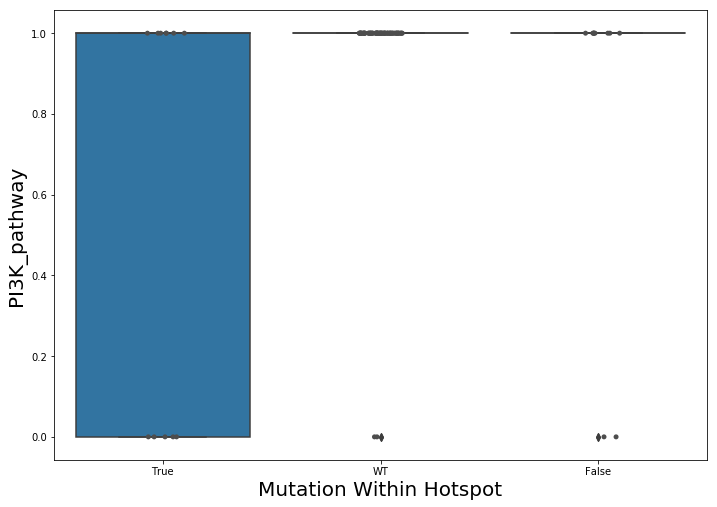

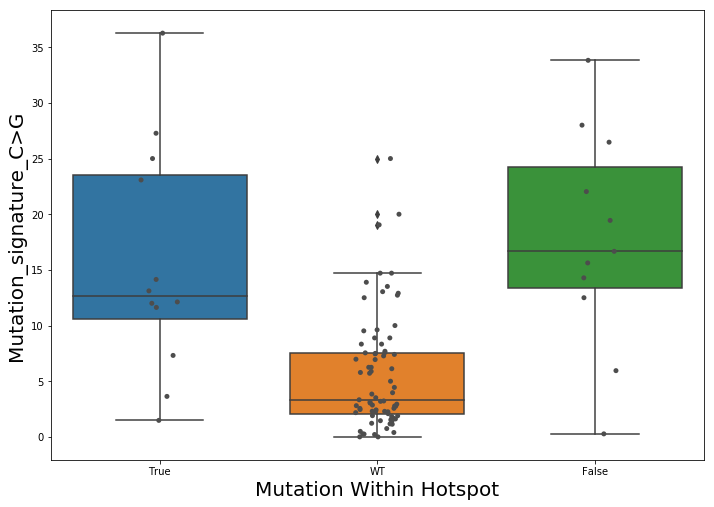

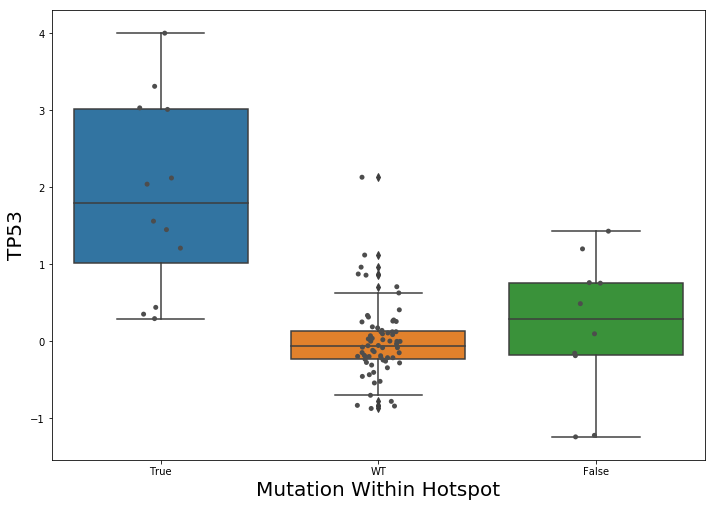

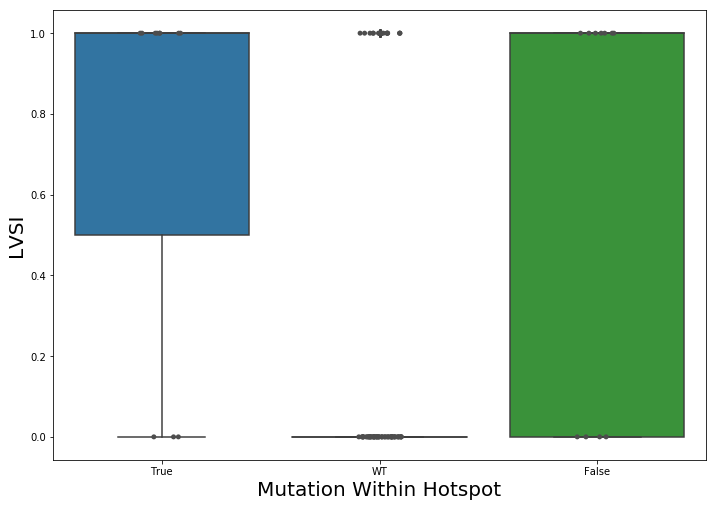

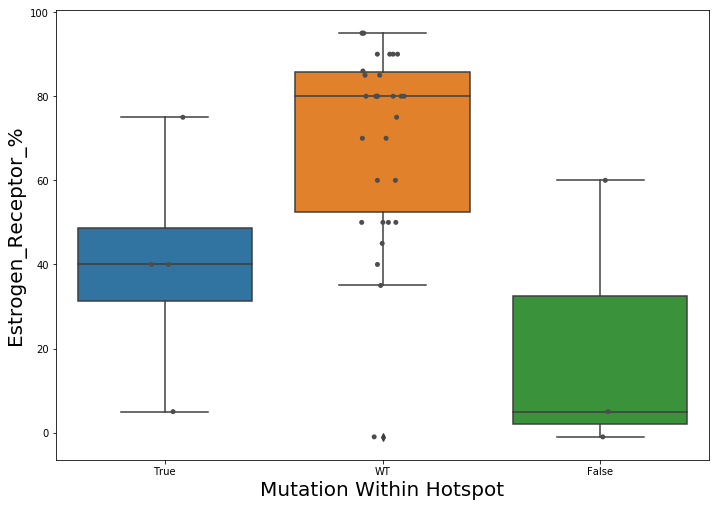

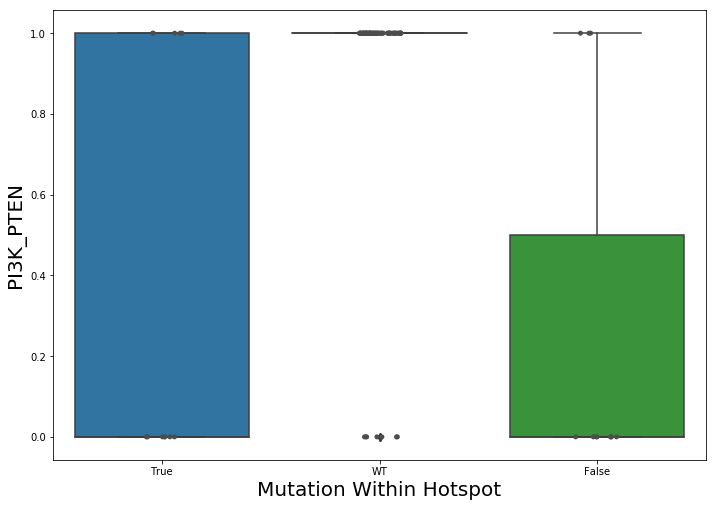

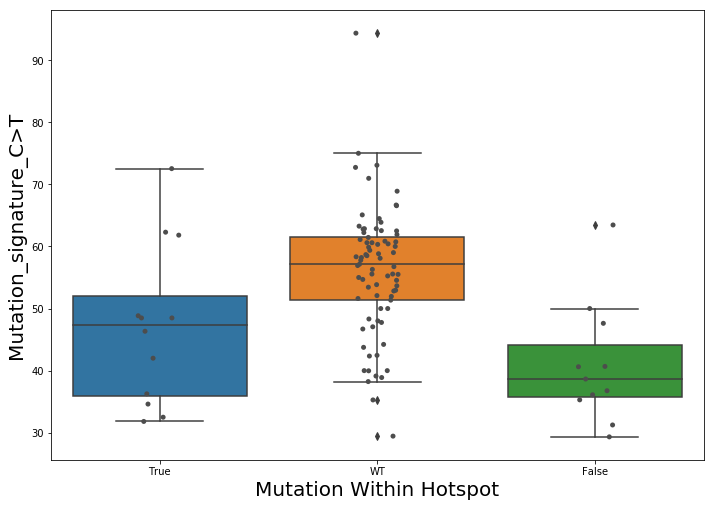

In [163]:
for feature in sig_list:
    Y_var = feature
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize = a4_dims)
    boxplt = sns.boxplot(data = clinical_full, x = 'Within_Hotspot', y = Y_var, ax = ax)
    boxplt = sns.stripplot(data = clinical_full, x = 'Within_Hotspot', y = Y_var, jitter = True, color = '.3')
    boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
    boxplt.set_ylabel(Y_var, fontsize='20')
    #boxplt.set_title("Effect of " + gene + " mutation on " + protein + " proteomics", fontsize='22')
    plt.show()

Histologic_type not found in dictionary. Alternatively, CPTAC.define() can be used to perform a web search of the term provided.


In [229]:
clinical_full['Histologic_type']

Proteomics_Participant_ID
C3L-00006      Endometrioid
C3L-00008      Endometrioid
C3L-00032      Endometrioid
C3L-00084    Carcinosarcoma
C3L-00090      Endometrioid
C3L-00098            Serous
C3L-00136      Endometrioid
C3L-00137      Endometrioid
C3L-00139            Serous
C3L-00143      Endometrioid
C3L-00145      Endometrioid
C3L-00156      Endometrioid
C3L-00157        Clear cell
C3L-00161      Endometrioid
C3L-00356    Carcinosarcoma
C3L-00358            Serous
C3L-00361      Endometrioid
C3L-00362      Endometrioid
C3L-00413      Endometrioid
C3L-00449      Endometrioid
C3L-00563      Endometrioid
C3L-00586      Endometrioid
C3L-00601      Endometrioid
C3L-00605      Endometrioid
C3L-00767      Endometrioid
C3L-00769      Endometrioid
C3L-00770      Endometrioid
C3L-00771      Endometrioid
C3L-00780      Endometrioid
C3L-00781      Endometrioid
                  ...      
C3N-00339            Serous
C3N-00340            Serous
C3N-00377      Endometrioid
C3N-00379      Endomet